In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as tk

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find column names for Measurement table

first_row = session.query(Measurement).first()

first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ec46b52fa0>,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

#### Column names for Measurement are keys in the dictionary generated above: 'id', 'station', 'date', 'tobs', and 'prcp'.

In [10]:
# Find column names for Station table

first_row_s = session.query(Station).first()

first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ec42283df0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

#### Column names for Station are keys in the dictionary generated above: 'name', 'id', 'station', 'latitude', 'longitude', and 'elevation'.

In [11]:
# Find the most recent date in the data set.

last_date = session.query(func.max(Measurement.date)).first()[0]

print(last_date)

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Turn last_date into a datetime object

last_date_dt = dt.datetime.strptime(last_date, '%Y-%m-%d')

year_ago = last_date_dt - dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores

year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).filter(Measurement.date <= last_date).all()

#for entry in year_data:
    #print(entry)

# Save the query results as a Pandas DataFrame

prcp_data_df = pd.DataFrame(year_data)

# Sort the dataframe by date
prcp_data_df_sort = prcp_data_df.sort_values('date')

# Set the index to the date column
prcp_data_new_index = prcp_data_df_sort.set_index('date')

# Drop NaNs 

no_nas = prcp_data_new_index.dropna(axis=0)
no_nas

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<Figure size 1440x864 with 0 Axes>

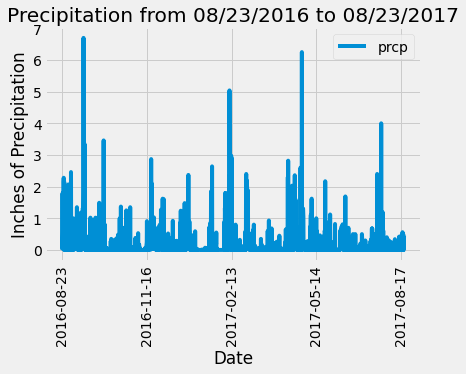

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(20,12))
index = no_nas.index
no_nas.plot()
plt.title('Precipitation from 08/23/2016 to 08/23/2017')
plt.ylabel('Inches of Precipitation')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data

prcp_data_new_index.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset

total_stations = session.query(Station.station).count()

total_stations

9

In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

In [33]:
station_activity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
most_active_id = station_activity[0][0]

most_active_id

'USC00519281'

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_id).all()[0]

for low in active_low:
    print(low)

54.0


In [36]:
active_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_id).all()[0]

for high in active_high:
    print(high)

85.0


In [37]:
active_mean = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_id).all()[0]

for mean in active_mean:
    print(mean)

71.66378066378067


In [30]:
last_date2 = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_id).first()[0]

last_date2

'2017-08-18'

In [31]:
last_date2_dt = dt.datetime.strptime(last_date2, '%Y-%m-%d')

year_ago2 = last_date2_dt - dt.timedelta(days = 365)

year_ago2

datetime.datetime(2016, 8, 18, 0, 0)

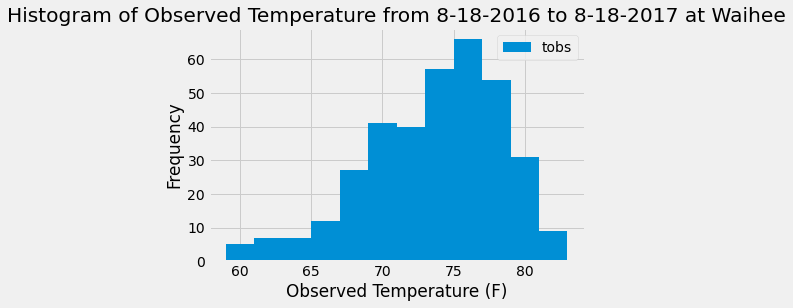

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data_year = session.query(Measurement.tobs).filter(Measurement.station == most_active_id).filter(Measurement.date >= year_ago2).filter(Measurement.date <= last_date2).all()

tobs_year_df = pd.DataFrame(temp_data_year)

plt.hist(tobs_year_df, bins = 12)
plt.legend(tobs_year_df)
plt.title("Histogram of Observed Temperature from 8-18-2016 to 8-18-2017 at Waihee")
plt.xlabel("Observed Temperature (F)")
plt.ylabel("Frequency")

plt.show()

# Close session

In [38]:
# Close Session
session.close()